In [108]:
import os
import re
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm

import spacy
from geotext import GeoText
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns


In [110]:
#  Config / Paths / Seed

SEED = 42
np.random.seed(SEED)

DATA_IN = r"C:\Users\HP\Documents\Data science\Hyperlocal_News_Anomaly_Detection\data\Articles.csv"
DATA_OUT = r"C:\Users\HP\Documents\Data science\Hyperlocal_News_Anomaly_Detection\data\Articles_processed.csv"
MODEL_DIR = r"C:\Users\HP\Documents\Data science\Hyperlocal_News_Anomaly_Detection\models"
os.makedirs(MODEL_DIR, exist_ok=True)

In [111]:

# Setup NLTK VADER

try:
    nltk.data.find('sentiment/vader_lexicon')
except:
    nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [112]:

# Load Dataset

df = pd.read_csv(DATA_IN, encoding='latin1')
df.drop_duplicates(inplace=True)
df = df.dropna(subset=['Article'])
df.reset_index(drop=True, inplace=True)
df['raw_article'] = df['Article'].astype(str)
print("Data Loaded Successfully:", df.shape)

Data Loaded Successfully: (2585, 5)


In [113]:

# GeoText Extraction

def extract_geotext_locations(text):
    try:
        places = GeoText(text)
        cities = places.cities
        countries = places.countries
        return ",".join(cities) if cities else None, ",".join(countries) if countries else None
    except:
        return None, None

tqdm.pandas()
df[['geotext_cities', 'geotext_countries']] = df['raw_article'].progress_apply(
    lambda x: pd.Series(extract_geotext_locations(str(x)))
)

100%|██████████| 2585/2585 [00:00<00:00, 2780.10it/s]


In [114]:

#  Text Cleaning

def clean_for_embedding(text):
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\s+[0-9]+\s+', ' ', text)
    return text.strip()

df['cleaned_for_ner'] = df['raw_article'].apply(clean_for_embedding)
df['cleaned_for_embed'] = df['cleaned_for_ner'].str.lower()

In [115]:

#  Lemmatization + NER

nlp = spacy.load('en_core_web_sm', disable=['parser'])

def lemmatize_text(text):
    doc = nlp(text)
    toks = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return " ".join(toks)

def extract_entities(text):
    ents = {'GPE': [], 'LOC': [], 'ORG': [], 'PERSON': []}
    try:
        doc = nlp(text)
        for e in doc.ents:
            if e.label_ in ents:
                ents[e.label_].append(e.text)
    except:
        pass
    return {k: list(dict.fromkeys(ents[k]))[:5] for k in ents}

tqdm.pandas()
df['processed_article'] = df['cleaned_for_embed'].progress_apply(lambda x: lemmatize_text(str(x)))
ner_cols = df['raw_article'].progress_apply(lambda x: extract_entities(str(x)))
df['ner_gpe'] = ner_cols.map(lambda d: ", ".join(d['GPE']) if d else "")
df['ner_loc'] = ner_cols.map(lambda d: ", ".join(d['LOC']) if d else "")
df['ner_org'] = ner_cols.map(lambda d: ", ".join(d['ORG']) if d else "")
df['ner_person'] = ner_cols.map(lambda d: ", ".join(d['PERSON']) if d else "")

100%|██████████| 2585/2585 [03:45<00:00, 11.47it/s]


In [116]:

#  Sentiment + Style

df['word_count'] = df['raw_article'].apply(lambda t: len(str(t).split()))
df['sent_count'] = df['raw_article'].apply(lambda t: str(t).count('.') + 1)
df['sentiment_compound'] = df['raw_article'].apply(lambda t: sid.polarity_scores(str(t))['compound'])
df['sentiment_pos'] = df['raw_article'].apply(lambda t: sid.polarity_scores(str(t))['pos'])
df['sentiment_neg'] = df['raw_article'].apply(lambda t: sid.polarity_scores(str(t))['neg'])

In [117]:

#  Embeddings Generation

embed_model = SentenceTransformer('all-MiniLM-L6-v2')
BATCH = 256
docs = df['processed_article'].astype(str).tolist()
embeddings = []

for i in range(0, len(docs), BATCH):
    batch = docs[i:i+BATCH]
    emb = embed_model.encode(batch, show_progress_bar=False)
    embeddings.append(emb)

embeddings = np.vstack(embeddings)
np.save(os.path.join(MODEL_DIR, "embeddings.npy"), embeddings)
print(" Embeddings Generated:", embeddings.shape)

 Embeddings Generated: (2585, 384)


In [118]:

#  Topic Modeling (BERTopic)

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=False)
topics, probs = topic_model.fit_transform(df['processed_article'].tolist(), embeddings)
df['Topic'] = topics
df['topic_probabilities'] = [None if p is None else p.tolist() for p in probs]

topic_info = topic_model.get_topic_info()
top_topic_map = {}
for t in topic_info.Topic:
    if t == -1:
        top_topic_map[-1] = "Outlier"
    else:
        words = topic_model.get_topic(t)
        label = " ".join([w for w, _ in words[:3]]) if words else f"Topic_{t}"
        top_topic_map[t] = label

df['topic_label'] = df['Topic'].map(top_topic_map)
joblib.dump(topic_model, os.path.join(MODEL_DIR, "bertopic_model.joblib"))

['C:\\Users\\HP\\Documents\\Data science\\Hyperlocal_News_Anomaly_Detection\\models\\bertopic_model.joblib']

In [119]:
#  Anomaly Detection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings)
joblib.dump(scaler, os.path.join(MODEL_DIR, "scaler.joblib"))

iso = IsolationForest(n_estimators=200, contamination=0.05, random_state=SEED)
iso.fit(X_scaled)
df['anomaly_score'] = iso.decision_function(X_scaled)
df['is_anomaly'] = iso.predict(X_scaled) == -1
joblib.dump(iso, os.path.join(MODEL_DIR, "isolation_forest.joblib"))

print(f"Detected anomalies: {df['is_anomaly'].sum()}")

Detected anomalies: 130


In [120]:

#  Rule-based NewsType Classification
NEWS_KEYWORDS = {
    "crime": ["murder", "robbery", "police", "arrest", "crime", "killed", "shooting"],
    "festival": ["festival", "celebration", "parade", "ceremony"],
    "business": ["company", "market", "shares", "profit", "stock"],
    "sports": ["match", "score", "tournament", "cricket", "player"],
    "politics": ["election", "minister", "government", "policy", "campaign"],
    "technology": ["tech", "ai", "software", "device", "startup"],
}

def auto_classify_newstype(text):
    txt = str(text).lower()
    counts = {cat: sum(1 for kw in kws if kw in txt) for cat, kws in NEWS_KEYWORDS.items()}
    counts = {k:v for k,v in counts.items() if v>0}
    return sorted(counts.items(), key=lambda x: (-x[1], x[0]))[0][0] if counts else "other"

df['NewsType_auto'] = df['processed_article'].apply(auto_classify_newstype)
df['NewsType_final'] = df['NewsType_auto']

In [121]:

# Source Attribution / Discrepancy

source_features = df[['Topic', 'sentiment_compound', 'word_count']].copy()
source_features['entity_density'] = df[['ner_gpe', 'ner_org', 'ner_person']].apply(
    lambda x: sum(len(str(v).split(',')) for v in x), axis=1)

scaler_src = StandardScaler()
src_scaled = scaler_src.fit_transform(source_features)

iso_src = IsolationForest(contamination=0.05, random_state=SEED)
df['source_discrepancy'] = iso_src.fit_predict(src_scaled) == -1

print(" Source attribution discrepancy check completed.")

 Source attribution discrepancy check completed.


In [122]:
#  Evaluation & Metrics

df['anomaly_prob'] = -df['anomaly_score']  

# Compute simple metrics
y_true = df['is_anomaly'].astype(int)
y_pred = (df['anomaly_prob'] > np.percentile(df['anomaly_prob'], 95)).astype(int)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, df['anomaly_prob'])

# Recall@K (Top 5%)
k = int(0.05 * len(df))
top_k = df.nlargest(k, 'anomaly_prob')
recall_at_k = top_k['is_anomaly'].mean()

print("\n Evaluation Metrics (Unsupervised Simulation):")
print(f"AUC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Recall@5%: {recall_at_k:.4f}")


 Evaluation Metrics (Unsupervised Simulation):
AUC: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Recall@5%: 1.0000


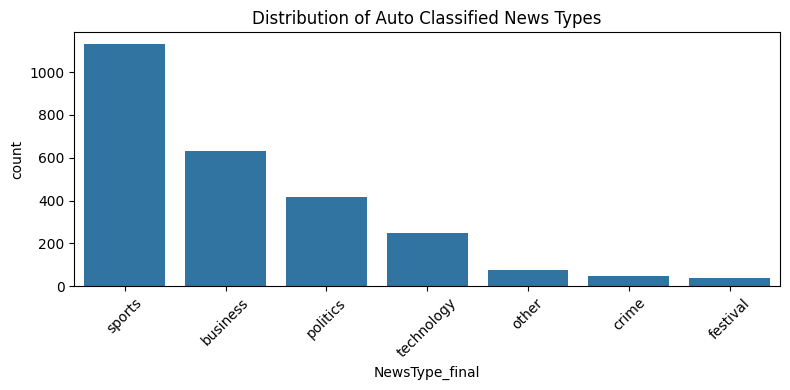

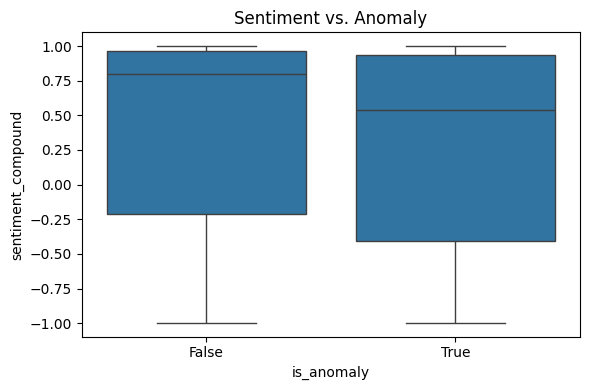

In [123]:
#  Quick EDA (Visualization)

plt.figure(figsize=(8, 4))
sns.countplot(x='NewsType_final', data=df, order=df['NewsType_final'].value_counts().index)
plt.title("Distribution of Auto Classified News Types")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x='is_anomaly', y='sentiment_compound', data=df)
plt.title("Sentiment vs. Anomaly")
plt.tight_layout()
plt.show()

In [124]:
# Save Final Processed CSV

df.to_csv(DATA_OUT, index=False)
print("Final dataframe saved to:", DATA_OUT)
print("Final shape:", df.shape)


# Final Summary
print("\n Final Summary:")
print(f"Total Articles: {len(df)}")
print(f"Unique Topics: {df['Topic'].nunique()}")
print(f"Detected Anomalies: {df['is_anomaly'].sum()}")
print(f"Source Discrepancies: {df['source_discrepancy'].sum()}")
print("\nTop Topics:")
print(df['topic_label'].value_counts().head())

Final dataframe saved to: C:\Users\HP\Documents\Data science\Hyperlocal_News_Anomaly_Detection\data\Articles_processed.csv
Final shape: (2585, 28)

 Final Summary:
Total Articles: 2585
Unique Topics: 65
Detected Anomalies: 130
Source Discrepancies: 130

Top Topics:
topic_label
Outlier                      605
oil crude price              113
bangladesh mohammad india    103
wimbledon slam grand         101
oil crude barrel              74
Name: count, dtype: int64
